In [1]:
import numpy as np
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from torch.utils.data import random_split, Dataset, DataLoader
from tqdm.notebook import tqdm
import sys
from IPython.display import clear_output
from torchvision.transforms import transforms
from PIL import Image
from torchvision.transforms.functional import crop

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [4]:
SEED = 0
VALIDATION_SIZE = 0.2
BATCH_SIZE = 16
LATENT_DIM = 100
EPOCHS = 10
LR = 1e-4
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
NOISE_FACTOR = 0.1

In [5]:
set_seed(SEED)

In [6]:
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [7]:
validation_data_size = int(len(data) * VALIDATION_SIZE)
train_data_size = len(data) - validation_data_size
train_data, valid_data = random_split(
    data, [train_data_size, validation_data_size]
    )

In [8]:
train_data_list = []
for image in train_data:
    image = torch.from_numpy(image)
    train_data_list.append(image)

valid_data_list = []
for image in valid_data:
    image = torch.from_numpy(image)
    valid_data_list.append(image)

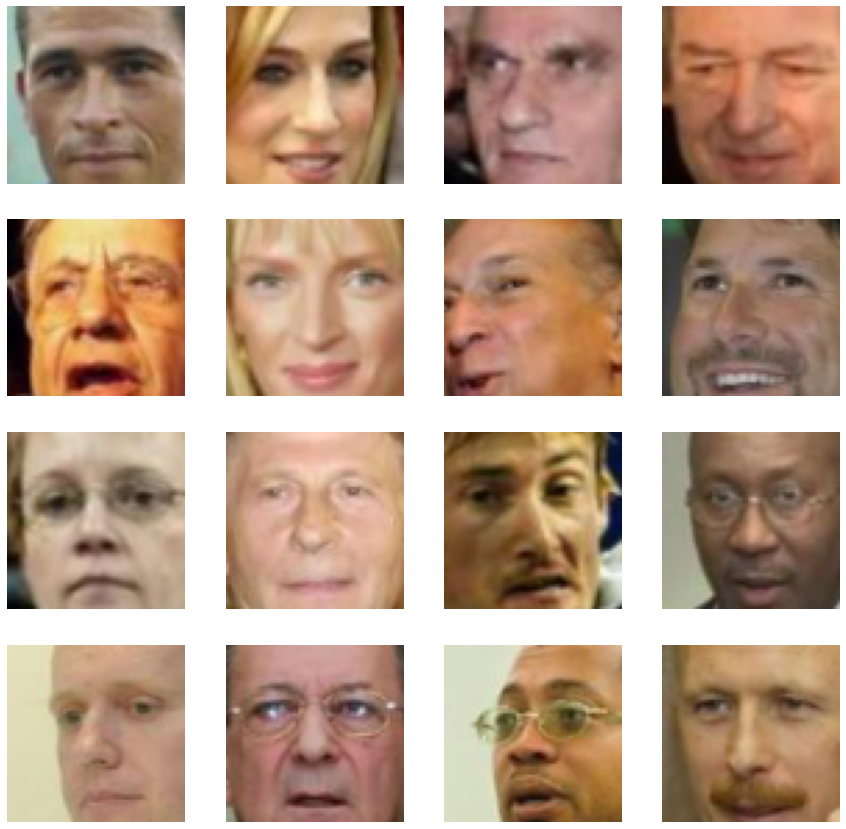

In [9]:
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
index = np.random.randint(0, 100)
for row in range(nrows):
    for col in range(ncols):
        image = train_data_list[index]
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        index += 1

In [10]:
train_dataloader = DataLoader(
    train_data_list, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
    )
valid_dataloader = DataLoader(
    valid_data_list, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
    )

In [11]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(                       # size = (batch_size, 32, 32, 32)
                in_channels=3,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.Conv2d(                       # size = (batch_size, 64, 16, 16)
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.Conv2d(                       # size = (batch_size, 64, 8, 8)
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.25),
        )

        self.fc_1 = nn.Linear(64*8*8, 64*8*4)
        self.mu = nn.Linear(64*8*4, latent_dim)
        self.log_var = nn.Linear(64*8*4, latent_dim)
        self.fc_2 = nn.Linear(latent_dim, 64*8*4)
        self.fc_3 = nn.Linear(64*8*4, 64*8*8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(             # size = (batch_size, 64, 15, 15)
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=2,
                padding=0,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.ConvTranspose2d(             # size = (batch_size, 64, 33, 33)
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.ConvTranspose2d(             # size = (batch_size, 3, 65, 65)
                in_channels=32,
                out_channels=3,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_1(x)
        mu = self.mu(x)
        log_var = self.log_var(x)

        return mu, log_var

    def sampler(self, mu, log_var):
        epsilon = torch.randn(mu.shape[0], mu.shape[1]).to(DEVICE)
        return mu + torch.exp(0.5*log_var) * epsilon

    def decode(self, z):
        z = self.fc_2(z)
        z = self.fc_3(z)
        z = z.reshape(-1, 64, 8, 8)
        reconstructed_img = self.decoder(z)
        reconstructed_img = transforms.Resize((64,64))(reconstructed_img)

        return reconstructed_img

    def forward(self, x):
        mu, logvar = self.encode(x)
        z_sample = self.sampler(mu, logvar)
        reconstruction = self.decode(z_sample)

        return mu, logvar, z_sample, reconstruction

In [12]:
def vae_loss_function(x, mu, logvar, reconstructed_images):
    log_likelihood = nn.BCELoss(reduction='none')
    bce_loss = log_likelihood(reconstructed_images, x)
    bce_loss = bce_loss.view(BATCH_SIZE, -1).sum(axis=1)
    bce_loss = bce_loss.mean()

    kl_divergence_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - torch.exp(logvar), axis=1
    )
    kl_divergence_loss = kl_divergence_loss.mean()
    return kl_divergence_loss + bce_loss

In [13]:
criterion = vae_loss_function
autoencoder = VariationalAutoencoder(LATENT_DIM)
optimizer = optim.Adam(autoencoder.parameters(), lr=LR)

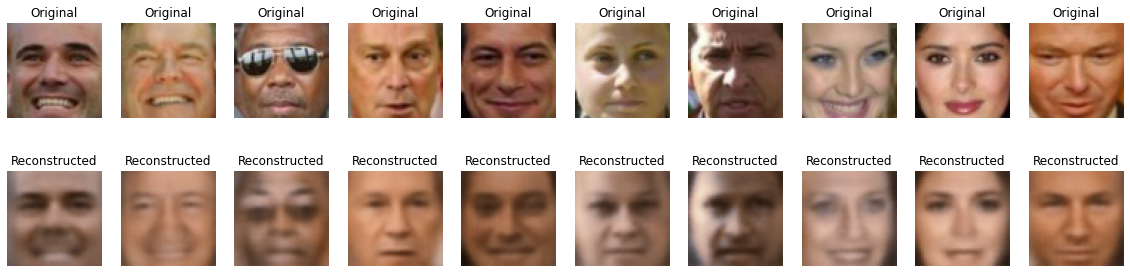

In [14]:
epochs = EPOCHS
autoencoder.double()

train_losses = []
validation_losses = []

for e in range(1, epochs+1):
    autoencoder.to(DEVICE)
    autoencoder.train()
    train_loss = 0
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for index, X_batch in enumerate(train_dataloader):
            X_batch = X_batch.to(DEVICE).double()
            X_batch = X_batch.permute(0, 3, 1, 2)

            optimizer.zero_grad()
            mu, logvar, z_sample, reconstruction = autoencoder(X_batch)
            loss = criterion(X_batch, mu, logvar, reconstruction)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            prbar.set_description(
                f'Epoch {e} train loss: {train_loss/(index+1)}'
            )
            prbar.update(1)
        
        train_losses.append(train_loss/(index+1))
    
    autoencoder.eval()
    validation_loss = 0
    with tqdm(total=len(valid_dataloader), file=sys.stdout) as prbar:
        for index, X_batch in enumerate(valid_dataloader):
            with torch.no_grad():
                X_batch = X_batch.to(DEVICE).double()
                X_batch = X_batch.permute(0, 3, 1, 2)

                mu, logvar, z_sample, reconstruction = autoencoder(X_batch)
                loss = criterion(X_batch, mu, logvar, reconstruction)

                validation_loss += loss.item()
                prbar.set_description(
                f'Epoch {e} valid loss: {validation_loss/(index+1)}'
                )
                prbar.update(1)

        validation_losses.append(validation_loss/(index+1))
    
    clear_output(wait=True)
    plt.figure(figsize=(20, 5))
    for image_number in range(10):
        plt.subplot(2, 10, image_number+1)
        original_image = np.transpose(X_batch[image_number].cpu(), (1, 2, 0))
        plt.imshow(original_image)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 10, image_number+11)
        reconstructed_image = np.transpose(
            reconstruction[image_number].detach().cpu(), (1, 2, 0)
            )
        plt.imshow(reconstructed_image)
        plt.title('Reconstructed')
        plt.axis('off')
    plt.show()

In [49]:
people_with_smile = attrs[attrs.Smiling > 0.5].index
people_wo_smile = attrs[attrs.Smiling < 0.5].index
smile_images = data[people_with_smile]
wo_smile_images = data[people_wo_smile]
smile_images = smile_images[:20]
wo_smile_images = wo_smile_images[:20]

smile_images = torch.Tensor(smile_images).to(DEVICE).double()
wo_smile_images = torch.Tensor(wo_smile_images).to(DEVICE).double()

smile_images = smile_images.permute(0, 3, 1, 2)
wo_smile_images = wo_smile_images.permute(0, 3, 1, 2)

In [50]:
mu_smile, _, z_sample_smile, _ = autoencoder(smile_images)
mu_wo_smile, _, z_sample_wo_smile, _ = autoencoder(wo_smile_images)

mean_latent_smile = torch.mean(z_sample_smile, axis=0)
mean_latent_wo_smile = torch.mean(z_sample_wo_smile, axis=0)

smile_vector = mean_latent_smile - mean_latent_wo_smile

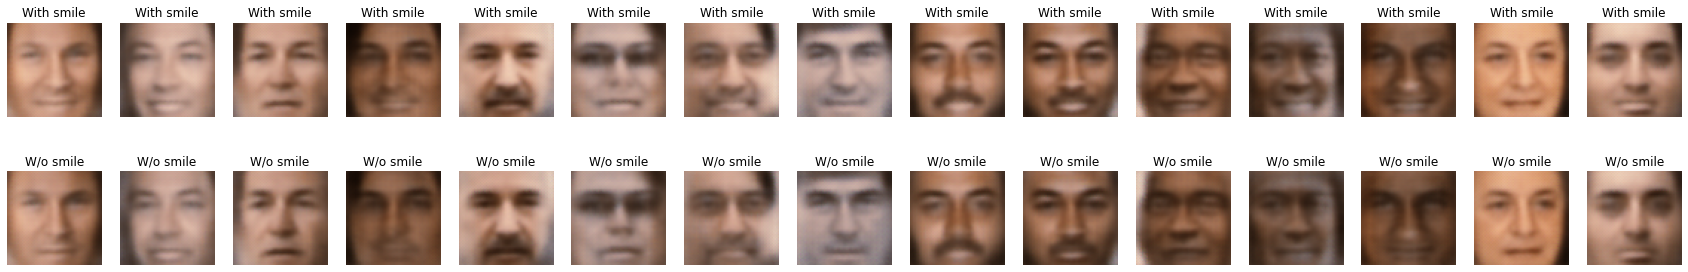

In [71]:
latent_serious_persons_with_smile = z_sample_wo_smile + smile_vector
serious_persons_with_smile = autoencoder.decode(latent_serious_persons_with_smile)
serious_persons_wo_smile = autoencoder.decode(z_sample_wo_smile)

serious_persons_with_smile = serious_persons_with_smile.permute(0, 2, 3, 1)
serious_persons_wo_smile = serious_persons_wo_smile.permute(0, 2, 3, 1)

plt.figure(figsize=(30,5))
for index in range(15):

    plt.subplot(2, 15, index+1)
    plt.imshow(serious_persons_with_smile[index].detach().numpy())
    plt.axis('off')
    plt.title('With smile')

    plt.subplot(2, 15, index+16)
    plt.imshow(serious_persons_wo_smile[index].detach().numpy())
    plt.axis('off')
    plt.title('W/o smile')

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [73]:
noisy_images_train = []
for image in train_data_list:
    noisy_image = image + NOISE_FACTOR * np.random.normal(
        loc=0.0, scale=1.0, size=image.shape
        )
    noisy_images_train.append(noisy_image)

noisy_images_valid = []
for image in valid_data_list:
    noisy_image = image + NOISE_FACTOR * np.random.normal(
        loc=0.0, scale=1.0, size=image.shape
        )
    noisy_images_valid.append(noisy_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


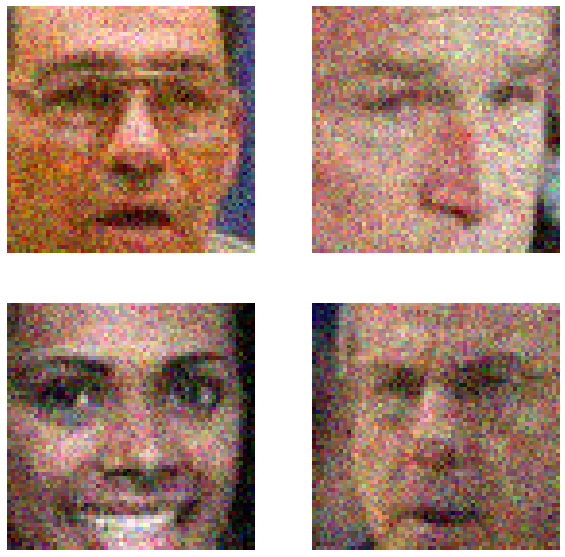

In [74]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
index = np.random.randint(0, 100)
for row in range(nrows):
    for col in range(ncols):
        image = noisy_images_train[index]
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        index += 1

In [75]:
class NoisyDataset(Dataset):
    def __init__(self, images, noisy_images):
        super(NoisyDataset, self).__init__()
        self.images = images
        self.noisy_images = noisy_images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        noisy_image = self.noisy_images[idx]
        return noisy_image, image

In [76]:
train_dataset = NoisyDataset(train_data_list, noisy_images_train)
valid_dataset = NoisyDataset(valid_data_list, noisy_images_valid)

In [77]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
    )
valid_dataloader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
    )

In [78]:
from torchvision.transforms.functional import center_crop

In [79]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(                       # size = (batch_size, 32, 32, 32)
                in_channels=3,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(                       # size = (batch_size, 64, 16, 16)
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(                       # size = (batch_size, 64, 8, 8)
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(             # size = (batch_size, 64, 15, 15)
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=2,
                padding=0,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(             # size = (batch_size, 64, 33, 33)
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(             # size = (batch_size, 3, 65, 65)
                in_channels=32,
                out_channels=3,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_x = self.encoder(x)
        reconstruction = self.decoder(latent_x)
        reconstruction = center_crop(reconstruction, [64,64])

        return latent_x, reconstruction

In [80]:
criterion = nn.MSELoss()
denoising_autoencoder = Autoencoder(LATENT_DIM)
optimizer = optim.Adam(denoising_autoencoder.parameters(), lr=LR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

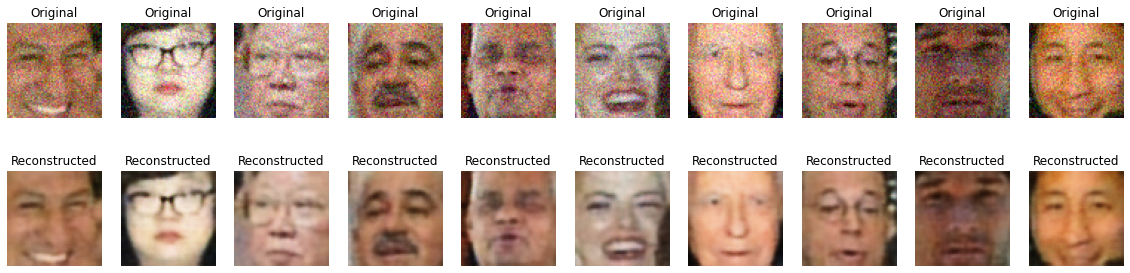

In [81]:
epochs = EPOCHS
denoising_autoencoder.double()

train_losses = []
validation_losses = []

for e in range(1, epochs+1):
    
    denoising_autoencoder.to(DEVICE)
    denoising_autoencoder.train()
    train_loss = 0
    
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for index, (X_batch, Y_batch) in enumerate(train_dataloader):
            
            X_batch = X_batch.to(DEVICE).double()
            X_batch = X_batch.permute(0, 3, 1, 2)
            Y_batch = Y_batch.to(DEVICE).double()
            Y_batch = Y_batch.permute(0, 3, 1, 2)

            optimizer.zero_grad()
            latent_x, reconstruction = denoising_autoencoder(X_batch)
            loss = criterion(reconstruction, Y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            prbar.set_description(
                f'Epoch {e} train loss: {train_loss/(index+1)}'
            )
            prbar.update(1)
        
        train_losses.append(train_loss/(index+1))
    
    denoising_autoencoder.eval()
    validation_loss = 0
    
    with tqdm(total=len(valid_dataloader), file=sys.stdout) as prbar:
        for index, (X_batch, Y_batch) in enumerate(valid_dataloader):
            with torch.no_grad():
                
                X_batch = X_batch.to(DEVICE).double()
                X_batch = X_batch.permute(0, 3, 1, 2)
                Y_batch = Y_batch.to(DEVICE).double()
                Y_batch = Y_batch.permute(0, 3, 1, 2)
                
                latent_x, reconstruction = denoising_autoencoder(X_batch)
                loss = criterion(reconstruction, Y_batch)

                validation_loss += loss.item()
                prbar.set_description(
                f'Epoch {e} valid loss: {validation_loss/(index+1)}'
                )
                prbar.update(1)

        validation_losses.append(validation_loss/(index+1))
    
    clear_output(wait=True)
    plt.figure(figsize=(20, 5))
    for image_number in range(10):
        plt.subplot(2, 10, image_number+1)
        original_image = np.transpose(X_batch[image_number].cpu().numpy(), (1, 2, 0))
        plt.imshow(original_image)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 10, image_number+11)
        reconstructed_image = np.transpose(
            reconstruction[image_number].detach().cpu().numpy(), (1, 2, 0)
            )
        plt.imshow(reconstructed_image)
        plt.title('Reconstructed')
        plt.axis('off')
    plt.show()

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>